<a href="https://colab.research.google.com/github/Shanti-27/Computer_Vision_Project/blob/main/Track_and_Count_Vehicles_using_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Advanced Vehicle Tracking and Counting Project**

**What This Project Is About**

Welcome to our exciting project where we'll learn to use a computer to count and track vehicles in a video. Imagine you have a video of a road with cars, buses, and bikes moving around, and you want to count each type of vehicle. We're going to do just that, but we'll let the computer do the hard work!


**The Tools We're Using**

To make this happen, we're using two special tools:

**YOLOv8**

This is a smart computer program that looks at pictures or videos and can spot different things like cars and bikes. YOLOv8 is really quick and accurate, which makes it perfect for finding all the vehicles in our video.

**ByteTrack**

After we find the vehicles with YOLOv8, we use ByteTrack to keep track of them. It's like a helper that makes sure we don't lose sight of any vehicle as it moves across the video.

**Supervision**

We also use a method called "supervision" to teach our computer program. We show it videos where we already marked all the vehicles. By studying these examples, the program learns how to find and follow vehicles in new videos.

**What We'll Learn**

By the end of this notebook, you'll know how to use YOLOv8 and ByteTrack to automatically find, follow, and count vehicles. This is really useful for things like studying traffic patterns or managing parking lots. So let's dive in and see how we can teach a computer to understand and analyze traffic just like us!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon Jun 19 04:01:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Checks if a NVIDIA GPU is available, important for running high-performance tasks like video processing and deep learning.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


Imports the os module and sets HOME to the current working directory, then prints it. This helps in understanding and managing file paths in the project.


## Download video

In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

Changes the directory to HOME and downloads a video file (vehicle-counting.mp4) from a Google Drive link. This video is likely used for vehicle tracking and counting. The command involves complex steps to handle the Google Drive download process.

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

Sets the path to the downloaded video file for later use in the project.

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.119 ðŸš€ Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete âœ… (4 CPUs, 25.5 GB RAM, 24.1/166.8 GB disk)


Installs the Ultralytics package, which likely includes the YOLOv8 model, and then checks the setup. This is crucial for object detection tasks.

## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


Clones the ByteTrack repository from GitHub into the project directory and installs its dependencies. ByteTrack is used for tracking objects across video frames.

In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


Installs a specific version of the supervision package and prints its version. This package is likely used for visualization or managing video data in the project.

In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

Imports various classes and functions from the supervision package related to video processing and annotations. These are used for handling video frames, drawing utilities, and tools for detections and counting.

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

Imports various classes and functions from the supervision package related to video processing and annotations. These are used for handling video frames, drawing utilities, and tools for detections and counting.

## Load pre-trained YOLOv8 model

In [ ]:
# settings
MODEL = "yolov8x.pt"

Sets a variable MODEL to the filename of a specific YOLOv8 model (here, "yolov8x.pt"). This indicates which pre-trained YOLO model will be used for object detection.


In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 131M/131M [00:00<00:00, 234MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients


Imports the YOLO class from Ultralytics and loads the specified model. The model is then prepared for inference (.fuse()). This step is critical for performing object detection on the video frames.


## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 3 cars, 1 truck, 66.5ms
Speed: 14.1ms preprocess, 66.5ms inference, 22.4ms postprocess per image at shape (1, 3, 640, 640)


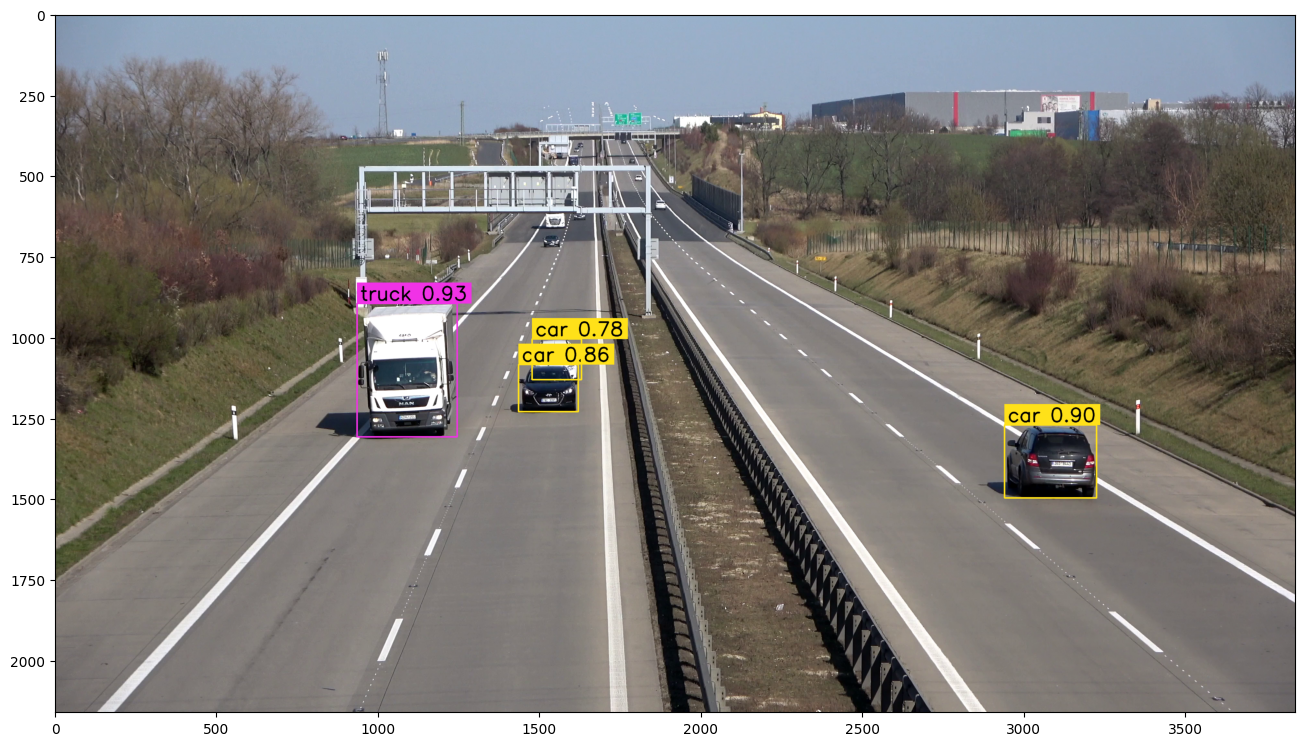

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

Sets up a generator to read frames from the video. Then, it uses the YOLO model to detect objects in a single frame and converts the results into a format suitable for annotation. The detections are labeled, and the frame is annotated with bounding boxes and labels. This cell demonstrates how object detection works on a video frame.


## Predict and annotate whole video

In [ ]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

Defines settings for a line counting feature, specifying the start and end points of a line across which vehicles will be counted. It also sets the path for the output video file. This is likely part of the vehicle counting mechanism in the project.


In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

This cell is the core of the project. It initializes the ByteTrack tracker, line counter, and annotators for boxes and lines. The loop processes each frame of the video: it performs object detection, filters and tracks detections, updates the line counter, and annotates the frame with bounding boxes, labels, and line annotations. The processed frames are then written to an output video file. This comprehensive code block handles the entire process of detecting, tracking, counting, and annotating vehicles in the video.


# **CONCLUSION**

The "Track and Count Vehicles using YOLOv8" project is a comprehensive and technically advanced endeavor that combines state-of-the-art object detection and multi-object tracking technologies to address the complex challenge of vehicle detection, tracking, and counting in video footage. Utilizing YOLOv8, a highly efficient and accurate object detection model, the project successfully identifies various vehicles in each frame of a video. The integration of ByteTrack, an advanced tracking algorithm, enables the tracking of these vehicles across frames, maintaining their identities even under challenging conditions.

The project also employs the supervision package for effective video frame handling, annotation, and visualization, enhancing the overall analysis and presentation of results. Custom functions are developed to streamline the process of converting detection results for tracking and matching purposes. Additionally, the implementation of a line counting feature adds another dimension to the project, allowing for the counting of vehicles crossing a defined line, which is valuable for traffic analysis and management applications.

Overall, this project serves as an exemplary demonstration of applying cutting-edge AI and computer vision techniques to real-world problems. It showcases the potential of deep learning in transforming how we understand and analyze complex scenarios like traffic flow and vehicle behavior. The project not only provides a practical solution to vehicle tracking and counting but also offers a valuable learning experience for those interested in the fields of computer vision and deep learning.


**"The project benefited from the integration of Roboflow, a valuable tool in computer vision, for streamlined data preprocessing and management."**
